In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import pickle as pkl
import statsmodels.api as sm
from scipy.stats import norm
from scipy.optimize import curve_fit
import pylab
import os
from kneed import DataGenerator, KneeLocator
from prediction_model import utils
from prediction_model.utils import compute_parameters
from scipy import stats
import itertools
import math

from sklearn.linear_model import LogisticRegression

# Trend

- Clear trend among all programs - H(HotSpot) < H(J9) < H(JikesRVM)

In [3]:
result_location = "/media/arjun/Shared/chaos/output_files_v2"
experiment_id = 6822382

directory = os.path.join(result_location, "rademacher_test_{}".format(experiment_id))

In [4]:
file_list = os.listdir(directory)
file_list = [ '.'.join(file.split('.')[:2]) for file in file_list if 'params.pkl' in file ]
print(file_list)

[]


In [6]:
file_list = os.listdir(directory)
# print(file_list)

hidden_size_list = np.sort(np.unique([ int(file_name.split('_')[1]) for file_name in file_list ]))
# print(hidden_size_list)
param_list = [ compute_parameters.get_count(100, 100, [ val, val ], ['lstm', 'fcn']) 
              for val in hidden_size_list ]

startp_list = np.sort(np.unique([ int(file_name.split('_')[2].split('.')[0]) for file_name in file_list ]))

program_list = list(set([ file_name.split('_')[0] for file_name in file_list ]))

print(program_list)
print(param_list)
print(startp_list)

['sunflow-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'xalan-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'pmd-small-J9-d-l64-p4096-w100000i.analyzed-1', 'luindex-small-J9-d-l64-p4096-w100000i.analyzed-1', 'sunflow-small-J9-d-l64-p4096-w100000i.analyzed-1', 'xalan-small-J9-d-l64-p4096-w100000i.analyzed-1', 'avrora-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'pmd-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'lusearch-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'luindex-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'luindex-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'avrora-small-J9-d-l64-p4096-w100000i.analyzed-1', 'pmd-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1', 'xalan-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'lusearch-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'sunflow-small-HotSpot-d-l64-p4096-w100000i.analyzed-1', 'lusearch-small-J9-d-l64-p4096-w100000i.analyzed-1', 'avrora-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1']
[404, 712, 1984

Program: sunflow-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1


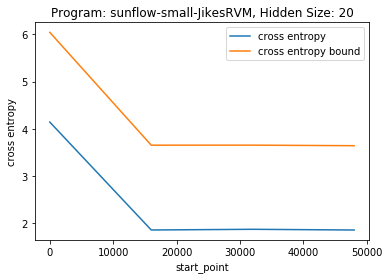

Program: xalan-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1


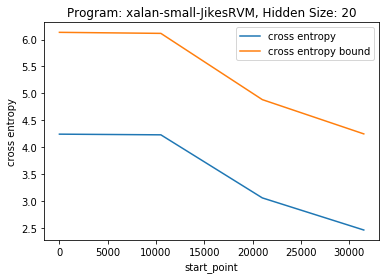

Program: pmd-small-J9-d-l64-p4096-w100000i.analyzed-1


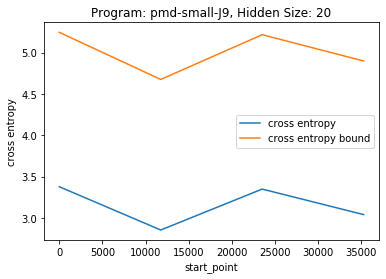

Program: luindex-small-J9-d-l64-p4096-w100000i.analyzed-1


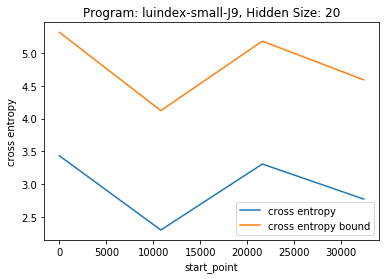

Program: sunflow-small-J9-d-l64-p4096-w100000i.analyzed-1


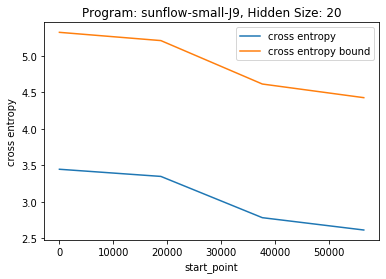

Program: xalan-small-J9-d-l64-p4096-w100000i.analyzed-1


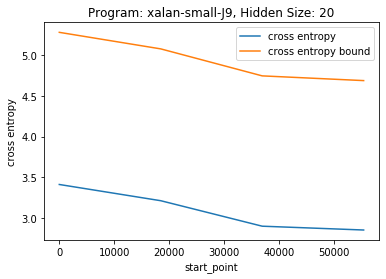

Program: avrora-small-HotSpot-d-l64-p4096-w100000i.analyzed-1


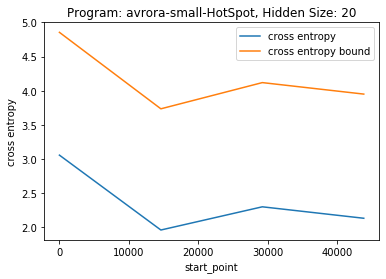

Program: pmd-small-HotSpot-d-l64-p4096-w100000i.analyzed-1


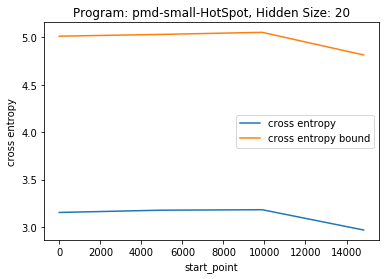

Program: lusearch-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1


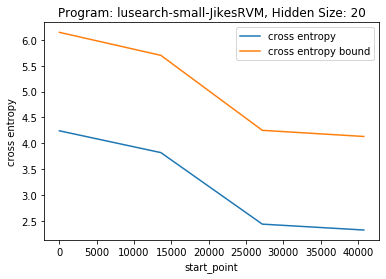

Program: luindex-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1


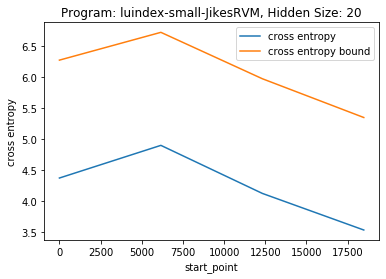

Program: luindex-small-HotSpot-d-l64-p4096-w100000i.analyzed-1


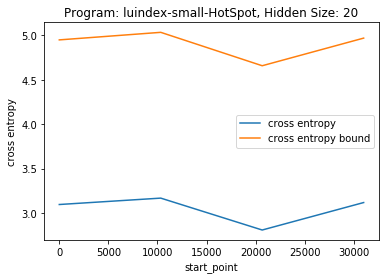

Program: avrora-small-J9-d-l64-p4096-w100000i.analyzed-1


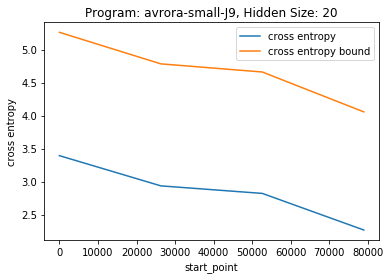

Program: pmd-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1


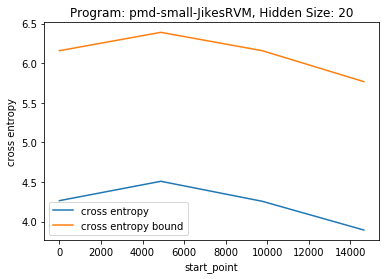

Program: xalan-small-HotSpot-d-l64-p4096-w100000i.analyzed-1


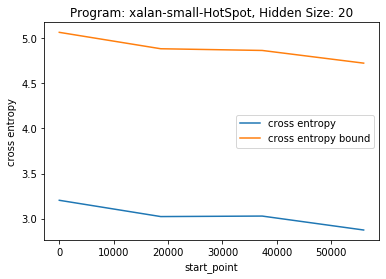

Program: lusearch-small-HotSpot-d-l64-p4096-w100000i.analyzed-1


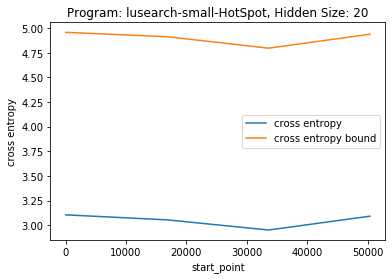

Program: sunflow-small-HotSpot-d-l64-p4096-w100000i.analyzed-1


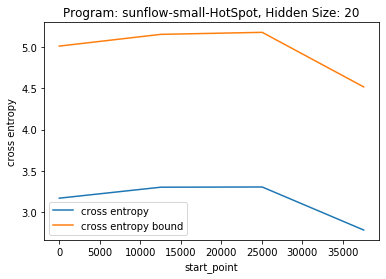

Program: lusearch-small-J9-d-l64-p4096-w100000i.analyzed-1


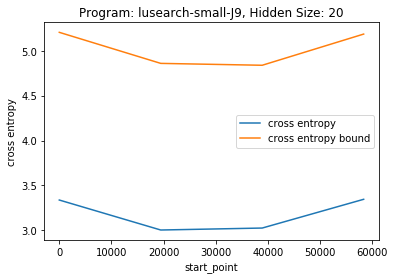

Program: avrora-small-JikesRVM-d-l64-p4096-w100000i.analyzed-1


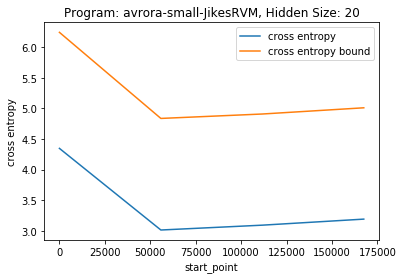

In [7]:
estimated_info = {}
estimated_mean = {}

for program in program_list:
    print("Program: {}".format(program))
    
    for hidden_size in [hidden_size_list[7]]:
        accuracy_list = []
        ce_list = []
        ce_bound_list = []
        ce_rad_list = []
        stp_list = []
        
        for start_point in startp_list:
            if os.path.exists(os.path.join(directory, 
                                           "{}_{}_{}.accuracy.pkl".format(program, hidden_size, start_point))):
                stp_list.append(start_point)
                with open(os.path.join(directory, "{}_{}_{}.accuracy.pkl".format(program, 
                                                                                 hidden_size,
                                                                                start_point)), 'rb') as f:
                    accuracy_list.append(pkl.load(f))

                with open(os.path.join(directory, "{}_{}_{}.ce.pkl".format(program, 
                                                                         hidden_size,
                                                                        start_point)), 'rb') as f:
                    ce_list.append(pkl.load(f))

                with open(os.path.join(directory, "{}_{}_{}.ceBound.pkl".format(program,  
                                                                                 hidden_size,
                                                                                start_point)), 'rb') as f:
                    ce_bound_list.append(pkl.load(f))

                with open(os.path.join(directory, "{}_{}_{}.ceRad.pkl".format(program,  
                                                                             hidden_size,
                                                                            start_point)), 'rb') as f:
                    ce_rad_list.append(pkl.load(f))
#         print(ce_list)
#         print(ce_bound_list)
        ce_list = [ np.mean(val) for val in ce_list ]
        ce_bound_list = [ val[0][0] for val in ce_bound_list ]
        plt.xlabel("start_point")
        plt.ylabel("cross entropy")
        plt.plot(stp_list, ce_list, label="cross entropy")
        plt.plot(stp_list, ce_bound_list, label="cross entropy bound")
        plt.title("Program: {}, Hidden Size: {}".format('-'.join(program.split('-')[:3]), hidden_size))
        plt.legend()
        plt.show()

In [5]:
print(estimated_info)

{'avrora-small-HotSpot': 4.744820348107683, 'avrora-small-J9': 5.06693145833517, 'avrora-small-JikesRVM': 6.422688684241188, 'luindex-small-JikesRVM': 6.411692543983114, 'lusearch-small-HotSpot': 4.687722860469289, 'sunflow-small-HotSpot': 4.922438180229589, 'sunflow-small-J9': 5.1630942692288775, 'sunflow-small-JikesRVM': 5.996453537445939, 'jython-small-HotSpot': 5.052447406786453, 'jython-small-J9': 5.134113926741422, 'lusearch-small-J9': 5.045402428203778, 'lusearch-small-JikesRVM': 6.409407929688772, 'pmd-small-HotSpot': 4.916449350719342, 'luindex-small-J9': 5.11710750626005, 'xalan-small-HotSpot': 5.031990505008772, 'xalan-small-J9': 5.047686761219797, 'xalan-small-JikesRVM': 6.188308553529445, 'jython-small-JikesRVM': 6.426629112535912, 'luindex-small-HotSpot': 4.897149502819588, 'pmd-small-J9': 5.044776711591624, 'pmd-small-JikesRVM': 6.197778317002661}


In [6]:
programs = np.unique([ val.split('-')[0] for val in list(estimated_info.keys()) ])
jvms = [ 'JikesRVM', 'J9', 'HotSpot' ]

In [13]:
for program in programs:
    info_list = []
    mean_list = []
    for jvm in jvms:
        info_list.append(estimated_info['-'.join([program, 'small', jvm])])
        mean_list.append(estimated_mean['-'.join([program, 'small', jvm])])
    print("{}: {}, {}, {}".format(program,
                              np.array(jvms)[np.argsort(info_list)],
                              np.array(mean_list)[np.argsort(info_list)],
                              np.array(info_list)[np.argsort(info_list)]))

avrora: ['HotSpot' 'J9' 'JikesRVM'], [2.88025377 3.17991635 4.47464686], [4.74482035 5.06693146 6.42268868]
jython: ['HotSpot' 'J9' 'JikesRVM'], [3.17609025 3.24697489 4.48114598], [5.05244741 5.13411393 6.42662911]
luindex: ['HotSpot' 'J9' 'JikesRVM'], [3.024266   3.2289499  4.46210098], [4.8971495  5.11710751 6.41169254]
lusearch: ['HotSpot' 'J9' 'JikesRVM'], [2.82014961 3.15823081 4.4633854 ], [4.68772286 5.04540243 6.40940793]
pmd: ['HotSpot' 'J9' 'JikesRVM'], [3.04650042 3.15870946 4.2565625 ], [4.91644935 5.04477671 6.19777832]
sunflow: ['HotSpot' 'J9' 'JikesRVM'], [3.04311948 3.27462981 4.06593894], [4.92243818 5.16309427 5.99645354]
xalan: ['HotSpot' 'J9' 'JikesRVM'], [3.15679947 3.16555925 4.25174627], [5.03199051 5.04768676 6.18830855]


In [8]:
a=np.ones((100))*1/100
print(np.sum(-a*np.log2(a)))

6.643856189774724


In [9]:
trace = pd.read_pickle(os.path.join("../../data", 
                                    "avrora-small-HotSpot-d-l64-p4096-w100000i.analyzed-1.pkl")).to_numpy()[1000:1000 + 5000]

In [10]:
hist = np.mean(trace, axis=0)

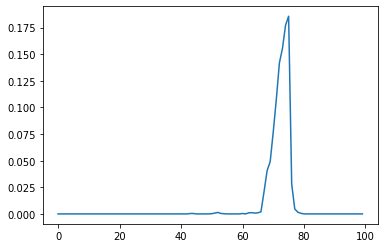

In [11]:
plt.plot(hist)

In [12]:
log_hist = np.clip(hist, 1e-10, 1)
-np.sum(hist * np.log2(log_hist))

3.1619699810175455